# Introduction to multislice simulations with *ab*TEM

This tutorial is a short introduction to transmission electron micrscopy simulations with *ab*TEM. The tutorial covers some basic principles such as potentials and wave functions and presents examples for STEM, CBED and HRTEM and simulations. For more in depth information, see the following resources:

* [The abTEM documentation](https://abtem.github.io/doc/intro.html)
* [The abTEM walkthrough](https://abtem.github.io/doc/user_guide/walkthrough/walkthrough.html)

### Contents:

1. <a href='#import'> Import atomic model
2. <a href='#potentials'> Potentials with the IAM
3. <a href='#probes'> Probe wave functions
5. <a href='#multislice'> Multislice simulation with Probe
6. <a href='#scan'> Scanned multislice simulation
7. <a href='#hrtem'> HRTEM simulation

### Author:
* 13/05/2024 Jacob Madsen - For the HyperSpy workshop at ePSIC 2024

In [1]:
%matplotlib widget

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(edgeitems=2)

abtem.config.set({"device": "cpu"})
abtem.config.set({"fft": "fftw"})

## Import atomic model <a id='import'></a>

To start running an image simulation, we need an atomic model. Creating an atomic model is covered in "atomic_models_with_ase.ipynb", if you do not have the file "sto_lto.cif", please run that notebook first.

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Side view'}, xlabel='y [Å]', ylabel='z [Å]'>)

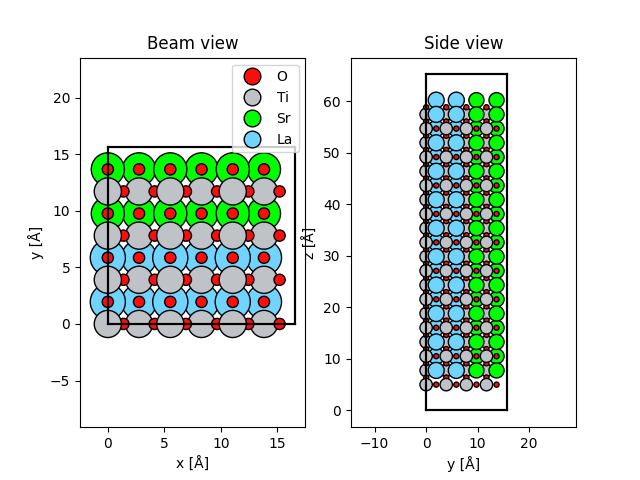

In [2]:
atoms = ase.io.read("sto_lto.cif")

fig, (ax1, ax2) = plt.subplots(1, 2)
abtem.show_atoms(atoms, ax=ax1, plane="xy", title="Beam view", legend=True)
abtem.show_atoms(atoms, ax=ax2, plane="yz", title="Side view")

## Creating `Potential`'s with the independent atom model <a id='potentials'></a>
We use the indepedent atom model (IAM) to create the electrostatic potential of the sample, in this model the potential is a superposition of a parametrization of single atomic potentials. More information on the potential in *ab*TEM may be found in the [walkthrough](https://abtem.github.io/doc/user_guide/walkthrough/potentials.html).

To define a `Potential`, we need to provide an ASE `Atoms` object, a sampling rate (or pixel size) in $x$ and $y$, and a slice thickness in the $z$-direction (the propagation direction). The multislice algorithm is only accurate in the limit of a good (small) sampling rate and thin slices, however, improving these parameters also increases computational cost. 

A sensible starting value for the sampling rate is between $0.05 \ \mathrm{Å}$ and $\mathrm{0.02} \ \mathrm{Å}$ and a slice thickness is between $1 \ \mathrm{Å}$ and $0.025 \ \mathrm{Å}$.

In [3]:
potential = abtem.Potential(atoms, sampling=0.05, slice_thickness=1)

The potential has 66 slices along the $z$ propagation direction, as may be determined from getting its length.

In [4]:
len(potential)

66

The `.build` method is available for many simulation objects. This method will convert a simulation object into a static array-based object. 

In [5]:
potential_array = potential.build()

*ab*TEM is evaluated lazily using the Dask library, this means that the resulting array is not computed immediately. We only created the instructions for computing the array. 

In [6]:
potential_array.array

dask.array<_wrap_build_potential, shape=(66, 332, 313), dtype=float32, chunksize=(66, 332, 313), chunktype=numpy.ndarray>

To run the computation we use the `.compute` method.

In [7]:
potential_array.compute()

[########################################] | 100% Completed | 2.12 ss


After computing the built potential is described as a NumPy array.

In [8]:
potential_array.array

array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)

We can show the projected potential using the `.show` method.

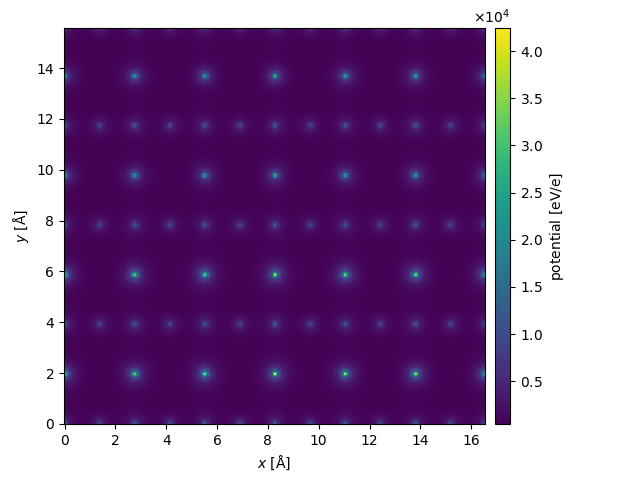

In [9]:
potential_array.show(cbar=True);

*ab*TEM has some features for showing the simulation objects interactively. Here, we convert the potential slice to a stack of images and show the result with `interact=True`, allowing us to scroll through slices. 

__Note__: This requires that the Matplotlib backend is using [`ipympl`](https://matplotlib.org/ipympl/).

In [10]:
potential_array.to_images().show(interact=True, cbar=True)

ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, description='z [Å]', options=('0.98…

## Creating `Probe` wave functions <a id='probes'></a>

The multislice algorithm works by propagating the $xy$ part a the wave function through the electrostatic potential along the $z$-axis. In STEM, the wave function is a focused beam of electrons. The convention used in abTEM is a probe defined by

$$
    \phi(\mathbf{k}, \mathbf{r}_0) = A(k) \exp(-i \chi(\mathbf{k})) \exp(-i 2 \pi \mathbf{k} \cdot \mathbf{r}_p) \quad ,
$$

where $\mathbf{k} = (k_x, k_y)$ is the spatial frequency, $A(k)$ is the condenser aperture function and $\chi(\mathbf{k})$ is the phase error and $\mathbf{r}_p = (x_p, y_p)$ is the probe position. See our [walkthrough section](https://abtem.github.io/doc/user_guide/walkthrough/contrast_transfer_function.html) on wave functions.

If the microscope is well aligned then off-axis aberrations are small and the phase error is dominated by defocus and spherical aberration

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) \quad ,
$$

where $\Delta f$ is the defocus and $C_s$ is the third order spherical aberration. See our [walkthrough section](https://abtem.github.io/doc/user_guide/walkthrough/contrast_transfer_function.html) on the contrast transfer function.

We create a probe with an energy of $200 \ \mathrm{keV}$, a convergence semiangle of $20 \ \mathrm{mrad}$, and a defocus of $50 \ \mathrm{Å}$.

__Note__: Positive defocus is equivalent to backward free-space propagation, i.e. a probe with positive defocus is "in focus" inside the sample.

In [11]:
probe = abtem.Probe(energy=150e3, defocus=50, semiangle_cutoff=20, Cs=0.)

We match our probe to our potential.

In [12]:
probe.grid.match(potential)

We can `.build` the probe to obtain an array representation.

In [13]:
probe_waves = probe.build()

probe_waves.array

dask.array<getitem, shape=(332, 313), dtype=complex64, chunksize=(332, 313), chunktype=numpy.ndarray>

In [14]:
probe_waves.compute()

[########################################] | 100% Completed | 203.73 ms


The wave function intensity can be shown in real or reciprocal space using the `.intensity` or `.diffraction_patterns` methods. 

__Note__: We used `grid.match`, hence the probe grid matches the potential. 

C:\Users\jacob\Downloads\WPy64-31180\python-3.11.8.amd64\Lib\site-packages\abtem\visualize\visualizations.py:183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


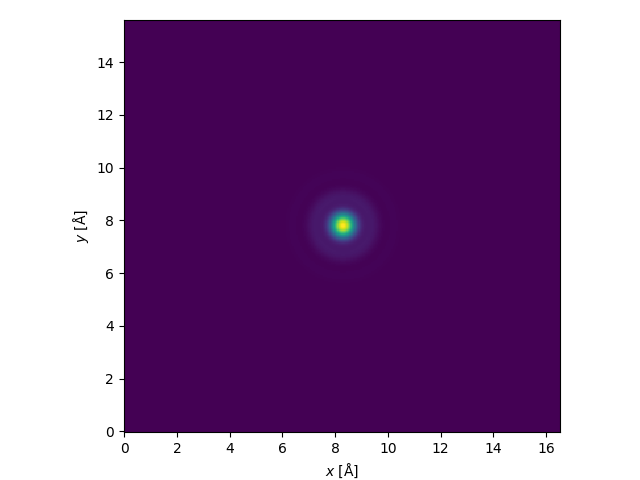

In [48]:
probe_waves.intensity().show()

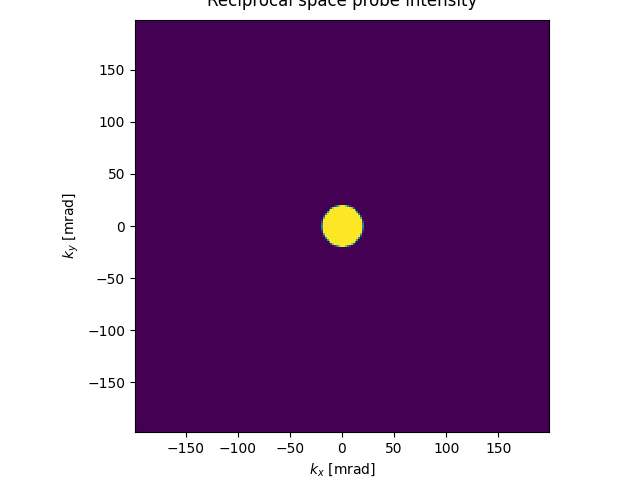

In [49]:
probe_waves.diffraction_patterns().show(
    title="Reciprocal space probe intensity", units="mrad"
);

We can create probes with multiple different values of defocus (or other parameters) by providing a sequence of values, e.g. as a NumPy array. Here we create an ensemble of $10$ probes with a defocus ranging from $0$ to $200 \ \mathrm{Å}$.

In [50]:
focal_series = np.linspace(0, 200, 5)

focal_series_probe = abtem.Probe(
    energy=200e3, defocus=focal_series, semiangle_cutoff=20, extent=10, sampling=0.05
)

We make an interactive visualization to scroll through the probe ensemble. 

__Note__: The probe `extent` is too small to represent a probe with the largest defocus in the series. We are seeing errors due to probe self-interaction causing the probe to have only four-fold rotational symmetry as a consequence of the square probe window.

In [51]:
focal_series_probe.build().compute().show(interact=True)

[########################################] | 100% Completed | 102.53 ms


ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, description='C10 [Å]', options=('-0…

As an alternative to the inteactive plots, we can set `explode=True` to show the entire ensemble.

[########################################] | 100% Completed | 102.78 ms


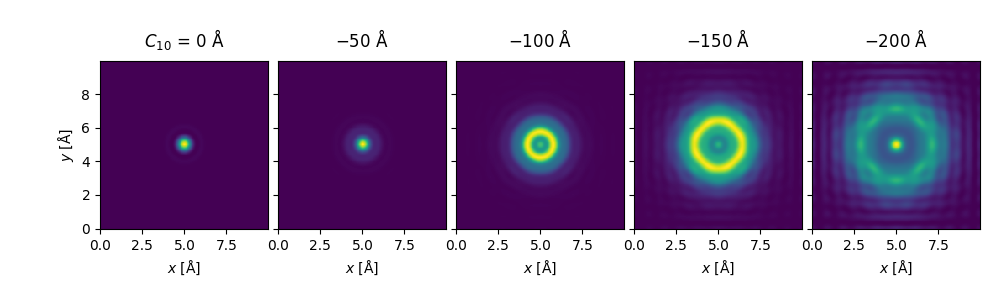

In [19]:
focal_series_probe.build().show(explode=True, figsize=(10, 3))

## Multislice simulation with a `Probe` (CBED) <a id='multislice'></a>
We use the multislice algorithm to propagate the probe through the potential. We can choose where to place the probe by setting the `scan` argument. Here we place the probe at $\mathbf{r}_p = (8,8) \ \mathrm{Å}$.

In [20]:
position = (8, 8)

exit_wave = probe.multislice(potential, scan=position)

We run `.compute` to calculate the exit waves.

In [21]:
exit_wave.compute()

[########################################] | 100% Completed | 2.14 sms


We can show the exit wave intensity.

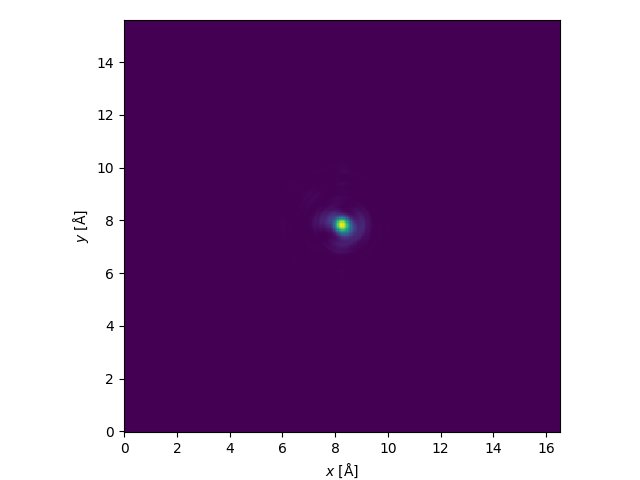

In [22]:
exit_wave_image = exit_wave.intensity()

exit_wave_image.show()

We can use an interactive visualization to show the diffraction on different power scales. 

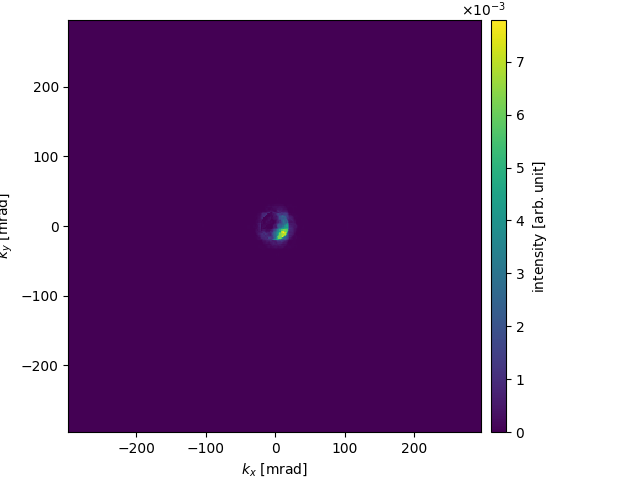

In [23]:
exit_wave_diffraction = exit_wave.diffraction_patterns(max_angle="full")

exit_wave_diffraction.show(cbar=True, units="mrad")

We set `max_angle="full"` above to show the diffraction pattern on the full simulation grid, however, the maximum available simulated angle does not correspond to full simulation grid.

The real-space sampling determines the maximum simulated scattering angle. The sampling defines the maximum spatial frequency $k_{max}$ via the formula:

$$ k_{max} = \frac{1}{2d} \quad , $$

where $d$ is the real-space sampling distance. To counteract aliasing artifacts due to the periodicity assumption of a discrete Fourier transform, abTEM supresses spatial frequencies above 2 / 3 of the maximum scattering angle, further reducing the maximum effective scattering angle by a factor of 2 / 3. Hence the maximum scattering angle $\alpha_{max}$ is given by:

$$ \alpha_{max} = \frac{2}{3}\frac{\lambda}{2p} \quad , $$

where $\lambda$ is the relativistic electron wavelength. 

## Scanned multislice simulation <a id='scan'></a>

Scanning imaging modes such as STEM works by rastering an electron probe across a sample pixel by pixel and recording the scattering signal. 

We create a grid scan and set the sampling (probe step size) to the Nyquist sampling of the probe. The image can be interpolated to the typically much higher experimental sampling rate.

We only scan across $1 / 3$ of the potential along $x$ because it is repeated three times in this direction. This is most conviniently done using fractional coordinates, which then requires us to provide the potential as well.

In [24]:
scan = abtem.GridScan(
    start=(0, 0),
    end=(1 / 3, 1),
    sampling=probe.ctf.nyquist_sampling,
    fractional=True,
    potential=potential,
)

We can show the scan region on top of the atoms to confirm. 

C:\Users\jacob\Downloads\WPy64-31180\python-3.11.8.amd64\Lib\site-packages\abtem\scan.py:1020: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle(


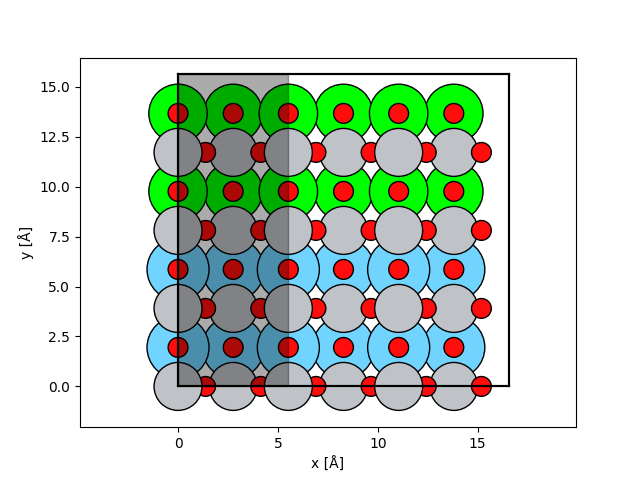

In [25]:
fig, ax = abtem.show_atoms(atoms)
scan.add_to_plot(ax, color="k")

__Note__: The scan `sampling` should not be confused with the wave function `sampling` due discretization. The former is equivalent to the probe step size, while the second has no experimental equivalent. 

In *ab*TEM the exit waves are "detected" using a detector object. There are several different types of detectors, the most basic, the `AnnularDetector`, may be used for bright-field, medium- or high-angle annular dark-field microscopy, depending on the integration region.

The integration region is given by an inner and outer radius in mrad; below we create three different types of detectors. We show the integration region of the HAADF detector.

In [26]:
bright = abtem.AnnularDetector(inner=0, outer=20)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=100, outer=180)

detectors = [bright, maadf, haadf]

The outer radius can only be as large as the maximum simulated scattering angle.

In [27]:
print(f"alpha_max = {min(probe.cutoff_angles):.1f} mrad")

alpha_max = 196.9 mrad


The detector regions, given a wave function, may be retrieved using the get detector region method.

In [28]:
bright_region = bright.get_detector_region(probe)
maadf_region = maadf.get_detector_region(probe)
haadf_region = haadf.get_detector_region(probe)

To conveniently show all the regions together we stack them, providing a name for each, and show them with `explode=True`.

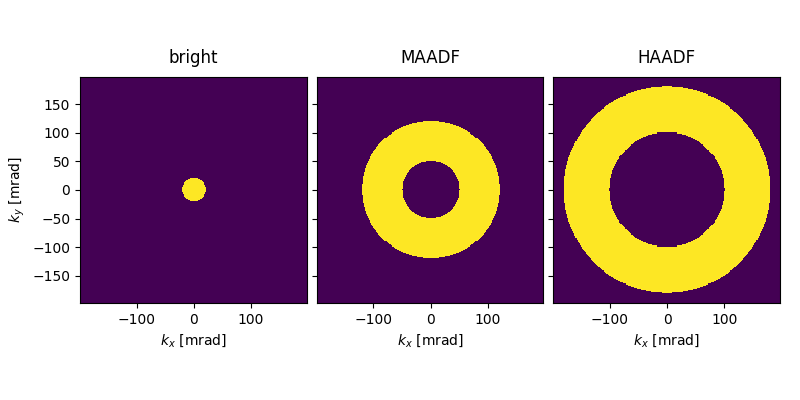

In [29]:
stacked_regions = abtem.stack(
    (bright_region, maadf_region, haadf_region), ("bright", "MAADF", "HAADF")
)

visualization = stacked_regions.show(explode=True, units="mrad", figsize=(8, 4))

The scanned multislice simulations are started as below, the simulation takes about 60s on my 2018 Macbook.

In [30]:
scanned_measurements = probe.scan(
    scan=scan,
    detectors=detectors,
    potential=potential,
)

scanned_measurements.compute()

[########################################] | 100% Completed | 91.24 s


The output is given as a list of three `Images` objects, one for each detector. We can stack show the measurements with `explode=True`.

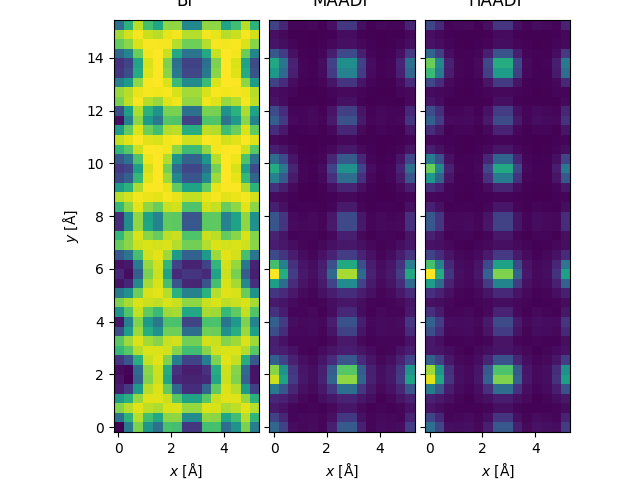

In [31]:
stacked_measurements = abtem.stack(scanned_measurements, ("BF", "MAADF", "HAADF"))

stacked_measurements.show(explode=True)

## Post-processing STEM measurements

STEM simulations usually requires some post-processing, we apply the most common steps below.

### Interpolation

We saved a lot of computational time by scanning at the Nyquist frequency, but the result is quite pixelated. To address this, we interpolate the images to a sampling of $0.1 \ \mathrm{Å / pixel}$. *ab*TEM's default interpolation algorithm is Fourier-space padding, but spline interpolation is also available, which is more appropriate if the image in non-periodic.

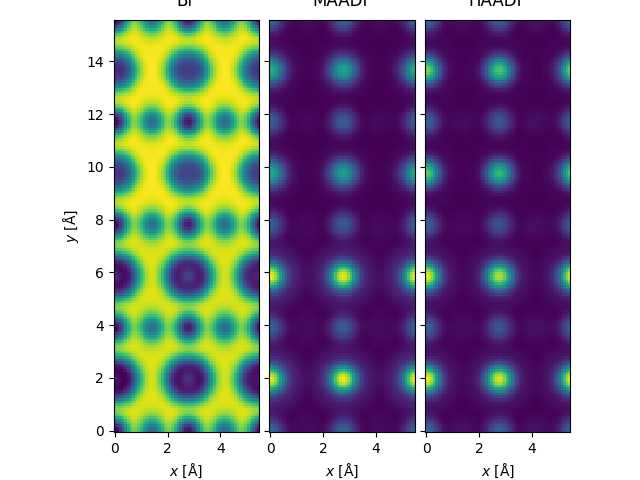

In [32]:
interpolated_measurements = stacked_measurements.interpolate(0.1)

interpolated_measurements.show(explode=True)

### Blurring

A finite Gaussian-shaped source will result in a blurring of the image. Vibrations and other instabilities may further contribute to the blur. We apply a Gaussian blur with a standard deviation of $0.5 \ \mathrm{Å}$ (corresponding to a source of approximately that size).

__Note__: We are not including partial temporal incoherence here. See our [tutorial on partial coherence](../tutorials/partial_coherence.ipynb).

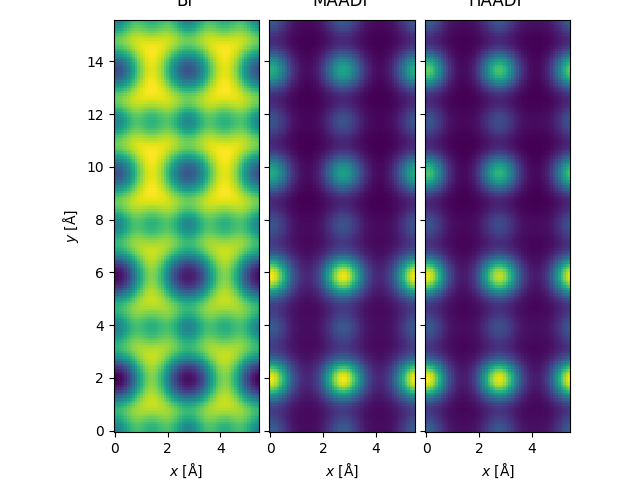

In [33]:
blurred_measurements = interpolated_measurements.gaussian_filter(0.35)

blurred_measurements.show(explode=True)

### Noise

Simulations such as the above corresponds to the limit of an infinite electron dose. We can get a random sample for a finite dose by drawing random numbers from a Poisson distribution for every pixel.

Before applying the noise, we tile the images to get better statistics.

In [34]:
tiled_measurements = blurred_measurements.tile((8, 3))

We apply Poisson noise corresponding a dose per area of $10^5 \ \mathrm{e}^- / \mathrm{Å}^2$.

In [35]:
noisy_measurements = tiled_measurements.poisson_noise(dose_per_area=1e4, seed=100)

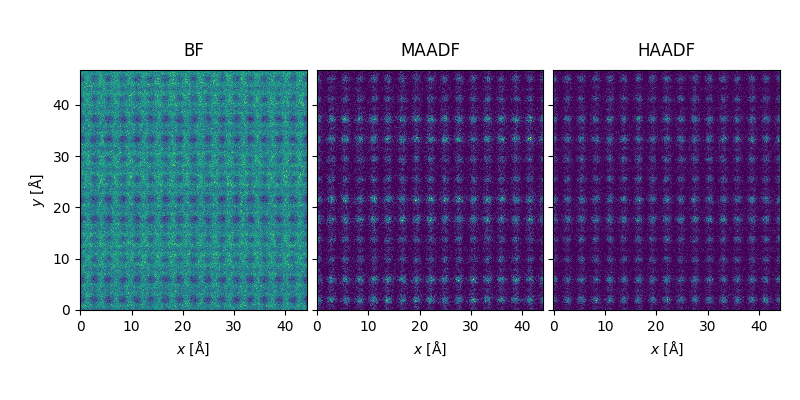

In [36]:
noisy_measurements.show(explode=True, figsize=(8, 4));

## HRTEM simulations with `PlaneWaves`'s <a id='hrtem'></a>

Running an HRTEM simulation is not very different from doing a CBED simulation. Instead of creating a `Probe`, we now create a `PlaneWave` with an energy of $150 \ \mathrm{keV}$.

In [37]:
plane_wave = abtem.PlaneWave(energy=150e3)

We will show an example of how to simulate a thickness series. To do this, we have to recreate our potential with the `exit_planes` argument. We set it to one to specify that we want an output exit wave for every single slice.

In [38]:
potential = abtem.Potential(atoms, sampling=0.05, slice_thickness=2, exit_planes=1)

__Note__: We did not define the wave function sampling, hence it will match the potential. We do not need to match the sampling of the wavefunction to an experimental pixel size, we can always interpolate the final result.

We run the mulislice algorithm. 

In [39]:
exit_wave = plane_wave.multislice(potential).compute()

[########################################] | 100% Completed | 1.41 ss


We show the exit wave intensity.

In [40]:
exit_wave.show(interact=True)

ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, description='z [Å]', options=('0.00…

We now have to specify the aberrations and aperture of the objective lens. 

We create a compatible `CTF` for electrons of the same energy as the plane wave of $150 \ \mathrm{keV}$. The spherical aberration will be set to $-20~\mu \mathrm{m}$ (remember that *ab*TEM uses units of $\mathrm{Å}$) and the defocus is set to the [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy).

In [41]:
Cs = -100e-6 * 1e10

# focal_series = np.linspace(0, 200, 5)

ctf = abtem.CTF(Cs=Cs, energy=150e3)

ctf.scherzer_defocus

-210.60771418586492

In [42]:
ctf.defocus = ctf.scherzer_defocus

We can show a radial profile of the `CTF`.

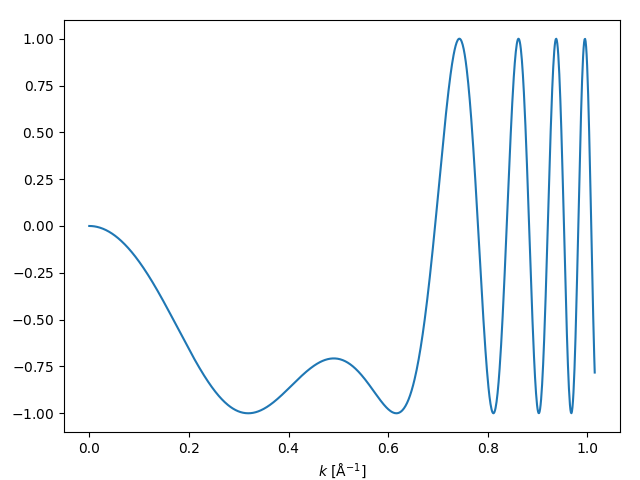

In [43]:
ctf.profiles(max_angle=30).show(overlay=True, legend=True)

The angle transferred to the detector plane is limited by the aperture of the objective lens. This is described as a multiplication with the aberration and aperture function:

$$
    \psi_{\mathrm{image}}(k, \phi) = A(k) \exp[-i \chi(k, \phi)] \psi_{\mathrm{exit}}(k, \phi) \quad ,
$$

where $A(k)$ is the aperture function

We will cut off the `CTF` at the angle corresponding to the Scherzer [point resolution](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy#Scherzer_defocus), which is defined as the angle where the phase of the `CTF` crosses the abscissa for the first time (`crossover_angle`).

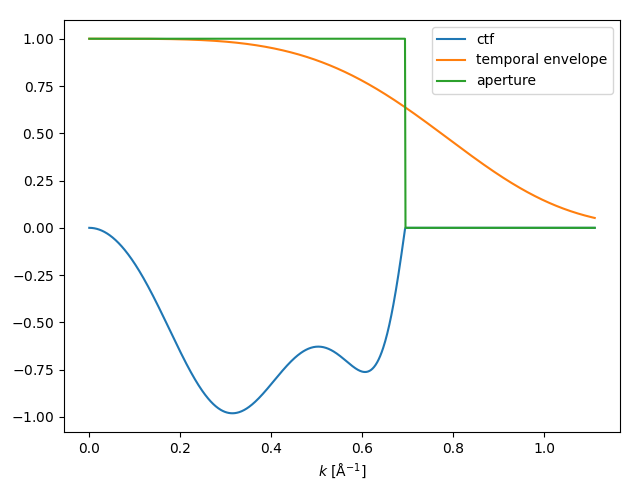

In [44]:
ctf.semiangle_cutoff = ctf.crossover_angle
ctf.focal_spread = 30

ctf.profiles().show(legend=True)

We apply the `CTF` to the exit wave to get the wave at the detector plane.

In [45]:
image = exit_wave.apply_ctf(ctf).intensity()

In [46]:
image.show(interact=True)

ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, description='z [Å]', options=('0.00…

As a last postprocessing step, we can tile the result and apply Poisson noise. 

In [47]:
noisy_image = image.tile((2, 2)).poisson_noise(1e4)

noisy_image.show(title="HRTEM image", interact=True)

ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, description='z [Å]', options=('0.00…